## Work
1. 請嘗試將 preproc_x 替換成以每筆資料的 min/max 進行標準化至 -1 ~ 1 間，再進行訓練
2. 請嘗試將 mlp 疊更深 (e.g 5~10 層)，進行訓練後觀察 learning curve 的走勢
3. (optional) 請改用 GPU 進行訓練 (如果你有 GPU 的話)，比較使用 CPU 與 GPU 的訓練速度

In [14]:
## 確認硬體資源
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Fri Mar 29 20:02:16 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 419.35       Driver Version: 419.35       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8    N/A /  N/A |    919MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [19]:
import os
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [20]:
train, test = keras.datasets.cifar10.load_data()

In [21]:
## 資料前處理
def preproc_x(x, flatten=True):
    
    original_shape = x.shape
    x = x.reshape((len(x), -1))
    x = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0)) * 2 - 1
    
    if not flatten:
        x = x.reshape(original.shape)
        
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

In [22]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape=x_train.shape[1:], output_units=y_train.shape[-1], num_neurons=[512, 256, 128]):
        
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
def plotting(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    loss = history['loss']
    val_loss = history['val_loss']
    acc = history['acc']
    val_acc = history['val_acc']
    
    epochs = range(1, len(loss) + 1)
    
    ax1.plot(epochs, loss, 'k.', label='training loss')
    ax1.plot(epochs, val_loss, 'b--', label='validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title(title)
    
    ax2.plot(epochs, acc, 'k.', label='training accuracy')
    ax2.plot(epochs, val_acc, 'b--', label='validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title(title)
    
    plt.tight_layout()
    plt.show()

In [8]:
## 超參數設定
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 256

In [9]:
def model_fitting(LR, EP, BS, input_shape=x_train.shape[1:], NN=[512, 256, 128]):
    
    keras.backend.clear_session()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    
    model = build_mlp(input_shape=input_shape)
    model.summary()
    
    optimizer = keras.optimizers.Adam(lr=LR)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    history = model.fit(x_train, y_train, 
                        epochs=EP, 
                        batch_size=BS, 
                        validation_data=(x_test, y_test), 
                        shuffle=False)
    
    sess.close()
    
    return history

In [10]:
history = model_fitting(LR=LEARNING_RATE, EP=EPOCHS, BS=BATCH_SIZE, NN=[1024, 512, 256, 128, 64, 32, 16])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 5s 104us/step - loss: 1

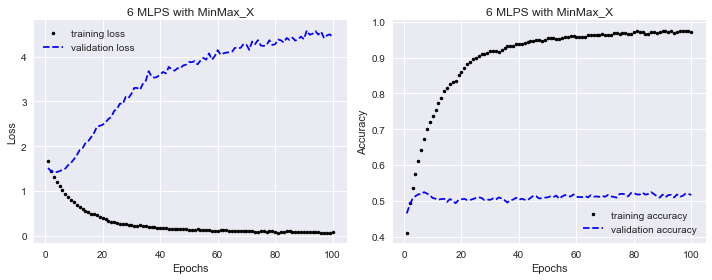

In [18]:
plotting(history.history, title='6 MLPS with MinMax_X')